<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/5_deepxde_alfa_correct_range_graph-ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Approximation of Hill-Type ODE

- ODE: $ \displaystyle \frac{dx}{dt} = \frac{x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}} $
- Condition: $ x(0) \approx b $, where $ b > 0 $ and $ \alpha \rightarrow 0 $ (stiff regime)
- Neural Solvers: PINNs with FNNs (32x4, 64x4)
- Baselines: RK45, BDF, Radau (SciPy)
- Focus: Accuracy around $ t \approx 0 $, where stiffness dominates

# 🧠 PINNs Meet Hill-Like ODEs  
**Can neural nets compete with trusted numerical solvers? Let's find out!**

- **ODE form**:  
  $ \displaystyle \frac{dx}{dt} = \frac{x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}} $ — steep, stiff, and nonlinear!
- **Setup**:
  - Initial state: $ x(0) \approx b $
  - We're in the $ \alpha \rightarrow 0 $ world (very sharp transitions).
- **Neural Nets**:
  - Feedforward networks (FNNs) trained via DeepXDE.
  - Multiple architectures tested: 32x4, 64x4, etc.
- **Numerical Solvers**:
  - `RK45` for adaptive precision  
  - `BDF` for stiffness  
  - `Radau` for stability  
- **Goal**: See how well PINNs approximate fast-changing dynamics vs. classical ODE solvers.


In [41]:
# Parameters
b = 1.0
x0 = b * 0.99999  # Initial condition x(0) ≈ b
nonuniformity_power = 3.0  # Controls how dense the points are near t = 1 (higher = denser)


!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle
from deepxde.callbacks import Callback

# Use float32 (по умолчанию)
tf.keras.backend.set_floatx('float32')
dde.config.set_default_float('float32')

dtype = "float32"
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_tensor_float_32_execution(True)

# Alpha range with potential small values (log-spaced)
#alpha = 0.01
#alpha_list = np.logspace(-2, -5, 10)  # от 0.01 до 0.00001 логарифмически
#alpha_list = np.logspace(-3, -7, 10)  # от 0.001 до 0.0000001: 2.78e-07 ok, 1.0e-07 NaN
#alpha_list = np.logspace(-5, -7, 10)  # от 0.00001 до 0.0000001
alpha_list = np.logspace(-5, -6.11, 10)  # от 1e-5 до ~1.3e-6
#alpha_list = np.logspace(-4, -9, 20)  # от 0.0001 до 0.000000001 логарифмически - много NaN

print("Alpha values (logspace):", alpha_list)

Set the default float type to float32
Alpha values (logspace): [1.00000000e-05 7.52777564e-06 5.66674061e-06 4.26579519e-06
 3.21119491e-06 2.41731548e-06 1.81970086e-06 1.36982998e-06
 1.03117727e-06 7.76247117e-07]



=== Training for alpha = 1.00000e-05 ===

Training model: FNN 64x4, domain=500
Compiling model...
Building feed-forward neural network...
'build' took 0.095647 s

'compile' took 0.982900 s

Training model...

Step      Train loss              Test loss               Test metric
0         [6.65e-04, 1.00e-10]    [1.48e-04, 1.00e-10]    []  
1000      [2.59e-09, 9.83e-08]    [2.59e-09, 9.83e-08]    []  
2000      [1.32e-09, 7.42e-08]    [1.31e-09, 7.42e-08]    []  
3000      [4.21e-10, 4.28e-08]    [4.20e-10, 4.28e-08]    []  
4000      [3.47e-11, 1.17e-08]    [3.42e-11, 1.17e-08]    []  
5000      [1.06e-09, 8.24e-09]    [1.06e-09, 8.24e-09]    []  

Best model at step 5000:
  train loss: 9.30e-09
  test loss: 9.30e-09
  test metric: []

'train' took 42.297276 s

Compiling model...
'compile' took 0.841967 s

Training model...

Step      Train loss              Test loss               Test metric
5000      [1.06e-09, 8.24e-09]    [1.06e-09, 8.24e-09]    []  
5018      [1.06e-09, 8.24e-0

/tmp/ipython-input-42-446929984.py:97: RuntimeWarning: All-NaN slice encountered
  line = f"{label}: α={alpha:.1e} x∈[{np.nanmin(x_pred):.4f},{np.nanmax(x_pred):.4f}] loss={loss_history.loss_train[-1][0]:.2e}"



=== Summary of all runs ===
FNN 64x4, domain=500: α=1.0e-05 x∈[0.9999,0.9999] loss=1.06e-09
FNN 64x4, domain=500: α=7.5e-06 x∈[0.9994,0.9995] loss=3.50e-08
FNN 64x4, domain=500: α=5.7e-06 x∈[0.9979,0.9994] loss=2.18e-06
FNN 64x4, domain=500: α=4.3e-06 x∈[0.9980,0.9994] loss=1.99e-06
FNN 64x4, domain=500: α=3.2e-06 x∈[0.9981,0.9994] loss=1.61e-06
FNN 64x4, domain=500: α=2.4e-06 x∈[0.9981,0.9994] loss=1.77e-06
FNN 64x4, domain=500: α=1.8e-06 x∈[0.9980,0.9994] loss=1.87e-06
FNN 64x4, domain=500: α=1.4e-06 x∈[0.9980,0.9994] loss=1.87e-06
FNN 64x4, domain=500: α=1.0e-06 x∈[0.9980,0.9994] loss=1.87e-06
FNN 64x4, domain=500: α=7.8e-07 x∈[nan,nan] loss=nan


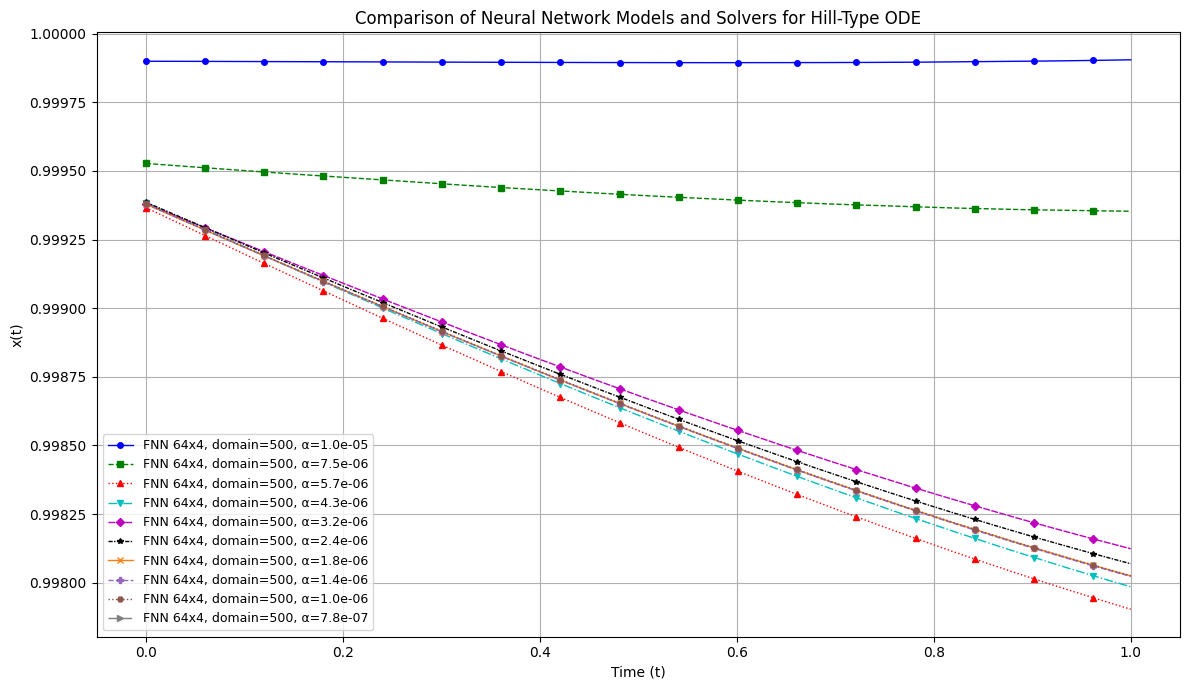

In [42]:
## Solution of ODE with Hill-like RHS: model comparison and approximation

# Define Hill-type equation generator (for dynamic alpha)
def get_hill_equation(alpha):
  def hill_equation(x, y):
     y_safe = tf.clip_by_value(y, 1e-6, 1e6)
     dy_t = dde.grad.jacobian(y, x, i=0, j=0) # dy/dt
     x_alpha = tf.pow(y_safe, 1 / alpha)      # x^(1/alpha)
     b_alpha = tf.pow(b, 1 / alpha)           # b^(1/alpha)
     return dy_t - x_alpha / (b_alpha + x_alpha)
  return hill_equation


# Time domain and initial condition
geom = dde.geometry.TimeDomain(0, 1)
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

# Model configurations to compare
#configs = [
#    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
#    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
#    (500, [1] + [128] * 6 + [1], "FNN 128x6, domain=500"),
#    (1000, [1] + [128] * 6 + [1], "FNN 128x6, domain=1000"),
#    (500, [1] + [128] * 8 + [1], "FNN 128x8, domain=500"),
#    (1000, [1] + [128] * 8 + [1], "FNN 128x8, domain=1000")
#]

configs = [
#    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
#    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
    (500, [1] + [64] * 4 + [1], "FNN 64x4, domain=500"),
]

# Prepare test time points (dense near t=0)
# Non-uniform test points: dense near t=0
N = 500
t_uniform = np.linspace(0, 1, N)  # Uniform grid in [0, 1]
#t_test = 1 - (1 - t_uniform) ** nonuniformity_power # Skew distribution toward t=1: more points near 1, fewer near 0
#t_test = np.unique(t_test).reshape(-1, 1) # Ensure strictly increasing and 2D

# Равномерное распределение точек:
t_test = t_uniform.reshape(-1, 1)  # Преобразуем в 2D массив (N x 1)


t_eval = np.sort(t_test.flatten())  # 1D массив для scipy

# Plot setup
plt.figure(figsize=(12, 7))
styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'v', 'D', '*', 'x', 'P', 'H', '>']
colors = ['b', 'g', 'r', 'c', 'm', 'k', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:gray']


# Train and evaluate neural models
results = []
all_losses = []
output_lines = []  # Создаем список для накопления строк вывода

for a_index, alpha in enumerate(alpha_list):
  print(f"\n=== Training for alpha = {alpha:.5e} ===")

  def rhs(t, x):                      # Define RHS for SciPy integration
    x_safe = np.clip(x[0], 1e-6, 1e6)
    x_alpha = x_safe ** (1 / alpha)
    b_alpha = b ** (1 / alpha)
    return [x_alpha / (b_alpha + x_alpha)]

  for i, (num_domain, architecture, label) in enumerate(configs):
    print(f"\nTraining model: {label}")
    data = dde.data.PDE(
        geom,
        get_hill_equation(alpha),
        ic,
        num_domain=num_domain,
        num_boundary=2,
        num_test=500
    )
    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")
    net.apply_output_transform(lambda x, y: y * 0.01 + b)
    model = dde.Model(data, net)
    model.compile("adam", lr=0.0001)
    loss_history, train_state = model.train(
        iterations=5000,
        display_every=1000,
        disregard_previous_best=True,
    )
    try:
        model.compile("L-BFGS")
        model.train(iterations=500)
    except Exception as e:
        print(f"L-BFGS failed for {label}: {str(e)}")

    x_pred = model.predict(t_test)
    results.append((t_test, x_pred, f"{label}, α={alpha:.1e}"))
    all_losses.append((f"{label}, α={alpha:.1e}", loss_history))

    line = f"{label}: α={alpha:.1e} x∈[{np.nanmin(x_pred):.4f},{np.nanmax(x_pred):.4f}] loss={loss_history.loss_train[-1][0]:.2e}"
    output_lines.append(line)  # Добавляем строку в список
    # print(line)  # По желанию - можно оставить вывод в реальном времени

    plt.plot(t_test, x_pred,
            linestyle=styles[a_index % len(styles)],
            color=colors[a_index % len(colors)],
            marker=markers[a_index % len(markers)],
            markevery=30, markersize=4,
            label=f"{label}, α={alpha:.1e}",
            linewidth=1.0)

print("\n=== Summary of all runs ===")
print("\n".join(output_lines))  # Выводим все строки через перевод строки

# Add numerical solutions
#plt.plot(sol_rk45.t, sol_rk45.y[0], 'k--', label='RK45 (SciPy)', linewidth=2)
#plt.plot(sol_bdf.t, sol_bdf.y[0], 'm:', label='BDF (SciPy)', linewidth=2)
#plt.plot(sol_radau.t, sol_radau.y[0], 'c-.', label='Radau (SciPy)', linewidth=2)

# Save results for visualization-only reruns
with open("nn_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Axis and title
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Comparison of Neural Network Models and Solvers for Hill-Type ODE")
plt.legend()
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
#plt.ylim(0.95, 0.975)
#plt.xlim(0, 0.02)
plt.show()

/tmp/ipython-input-43-1944663737.py:47: RuntimeWarning: invalid value encountered in power
  lambda x: (1 - x + epsilon)**power,  # Инвертируем (1-x) для сгущения справа


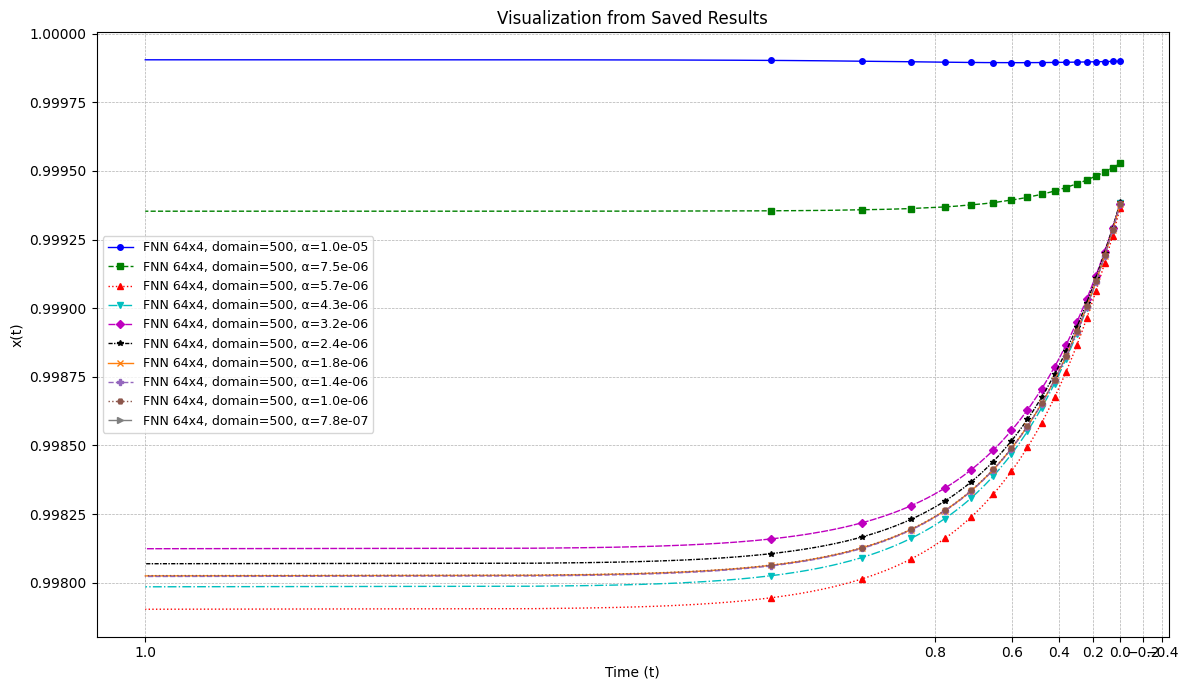

In [43]:
# Visualization block (can be run separately, new version)
import matplotlib.pyplot as plt
import pickle

# Load previously saved results
with open("nn_results.pkl", "rb") as f:
    results = pickle.load(f)


# Todo to include
#plt.plot(sol_rk45.t, sol_rk45.y[0], 'k--', label='RK45 (SciPy)', linewidth=2)
#plt.plot(sol_bdf.t, sol_bdf.y[0], 'm:', label='BDF (SciPy)', linewidth=2)
#plt.plot(sol_radau.t, sol_radau.y[0], 'c-.', label='Radau (SciPy)', linewidth=2)

# Styling parameters
styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'v', 'D', '*', 'x', 'P', 'H', '>']
colors = ['b', 'g', 'r', 'c', 'm', 'k', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:gray']

plt.figure(figsize=(12, 7))
for a_index, (t_test, x_pred, label) in enumerate(results):
    plt.plot(t_test, x_pred,
             linestyle=styles[a_index % len(styles)],
             color=colors[a_index % len(colors)],
             marker=markers[a_index % len(markers)],
             markevery=30, markersize=4,
             label=label,
             linewidth=1.0)

plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Visualization from Saved Results")

#plt.xscale("log")  # Use logarithmic scale on x-axis to highlight dense region near t=1
#plt.xscale('symlog', linthresh=0.01, linscale=0.1)
#plt.xscale('symlog',
#           linthresh=0.01,  # Порог перехода к логарифмической шкале
#           linscale=0.1,    # Масштабный коэффициент линейной области
           #subs=[2, 3, 4, 5, 6, 7, 8, 9])  # Дополнительные деления
#           base=2)  # Можно менять основание логарифма

power = 0.09    # Чем меньше, тем сильнее сгущение у 1 (0.05-0.5)
epsilon = 1e-6 # Добавим небольшое положительное смещение ε, чтобы избежать нуля

plt.xscale('function', functions=(
    # Прямое преобразование (data -> display)
    lambda x: (1 - x + epsilon)**power,  # Инвертируем (1-x) для сгущения справа

    # Обратное преобразование (display -> data)
    lambda x: 1 - (x**(1/power)) + epsilon
))


# Инвертируем ось для сгущения справа
# plt.gca().invert_xaxis()

plt.legend(fontsize=9)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()